## kNN TIP

In [1]:
#import some libraries

import pyodbc
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
from sqlalchemy import create_engine, MetaData, Table, select
import seaborn as sns
import sklearn
import nltk
from nltk import word_tokenize
# nltk.download()
#import rpy2
import spacy
import en_core_web_sm  # or any other model you downloaded via spacy download or pip
nlp = en_core_web_sm.load()
#import gensim

# load the R package ISLR
# infert = com.importr("ISLR")

# Enable inline plotting
%matplotlib inline

#Import and assign WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [2]:
#get some version info
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('NLTK version ' + nltk.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.2 |Anaconda custom (64-bit)| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]
Pandas version 0.20.3
NLTK version 3.2.4
Matplotlib version 2.0.2


### Use Windows Authentication to connect to SQL Server
#### Assign database=master to make sure we can connect to both ORD_INT and APPR_EXT

In [3]:
# assign server and db
server = 'ES11vADOSQL006'
db = 'master'

# Create the connection to all dbs
cnxn = pyodbc.connect('DRIVER={ODBC Driver 11 for SQL Server};SERVER=ES11vADOSQL006;DATABASE=master;Trusted_Connection=yes;')
# Connect to ORD_INT
#ORD_INT = pyodbc.connect('DRIVER={ODBC Driver 11 for SQL Server};SERVER=ES11vADOSQL006;DATABASE=ORD_INT;Trusted_Connection=yes;')

#### Create initial dataset by joining APPRTIP (teacher level TIP data, including text, meeting dates, etc) with TRD_APPR_Ratings_v (Reliable year over year Advance ratings at the teacher level)
#### Exclude teachers who are not Advance eligible, as well as those whose TIP ended due to an appeal and those which were never submitted through AWA

#### Calculate the number of calendar days between TIP meetings as recorded in AWA
#### Calculate word counts for each TIP section by dividing the total character count by 6.04 --> avg word length plus 1.25 for punctuation and spaces

In [4]:
# join APPRTIP and TRD_APPR_Ratings_v
# calculate word counts for 5 TIP sections
# calculate days between each TIP meeting
sql3 = """

SELECT a.*
,(datalength(a.TIPImprovementPlan1)/6.04) as IP_wrd_ct
,(datalength(a.TIPActionPlan)/6.04) as ActP_wrd_ct
,(datalength(a.TIPTimeLinePlan)/6.04) as TLP_wrd_ct 
,(datalength(a.TIPSupportPlan)/6.04) as SP_wrd_ct
,(datalength(a.TIPAssessmentPlan)/6.04) as AsmtP_wrd_ct 
,(datalength(a.TIPImprovementPlan1+a.TIPActionPlan+a.TIPTimeLinePlan+a.TIPSupportPlan+a.TIPAssessmentPlan)/6.04) as total_wrd_ct
,(a.TIPImprovementPlan1 + ' ' + a.TIPActionPlan + ' ' + a.TIPTimeLinePlan + ' ' + a.TIPSupportPlan + ' ' + a.TIPAssessmentPlan) as TIP_all_txt
,b.Last_Name
    ,b.First_Name
    ,b.Rating_DBN
    ,b.MOTP_Points
    ,b.MOTP_Rating
    ,b.MOSL_Points_Local
    ,b.MOSL_Rating_Local
      ,b.MOSL_Points_State
      ,b.MOSL_Rating_State 
      ,b.Overall_Points
      ,b.Overall_Rating
      ,b.TIPRating
      ,(DATEDIFF(dd, a.TIPMeeting1,a.TIPMeeting2)) AS days_bt_mt1_mt2
      ,(DATEDIFF(dd, a.TIPMeeting2,a.TIPMeeting3)) AS days_bt_mt2_mt3
      ,(DATEDIFF(dd, a.TIPMeeting3,a.TIPMeeting4)) AS days_bt_mt3_mt4
      ,(DATEDIFF(dd, a.TIPMeeting4,a.TIPMeeting5)) AS days_bt_mt4_mt5
FROM [APPR_EXT].[dbo].[APPRTIP] as a inner join [ORD_INT].[dbo].[TRD_APPR_Ratings_v] as b
on a.Employeeid = b.Employeeid AND a.FiscalYear = b.FiscalYear
where a.IsSubmitted = 'Y' and a.TIPEndedAppeal = 'N' and b.Advance_Eligibility_Status = 'Y'

"""
TIP_with_rats = pd.io.sql.read_sql(sql3, cnxn)
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Rating_Local,MOSL_Points_State,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21,NaT,...,,16.0,Effective,NaN,Effective,Effective,NaN,NaN,NaN,NaN
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16,2016-02-23,...,Effective,15.0,Effective,79.0,Effective,Effective,160.0,105.0,NaN,NaN
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21,2017-04-26,...,,16.0,Effective,NaN,Effective,Effective,217.0,NaN,NaN,NaN
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19,2017-01-31,...,,15.0,Effective,NaN,Effective,Effective,134.0,NaN,NaN,NaN
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22,2017-02-02,...,,16.0,Effective,NaN,Effective,Effective,133.0,130.0,NaN,NaN


In [5]:
TIP_with_rats = TIP_with_rats.fillna('')

In [6]:
TIP_with_rats['TIP_all_txt'] = TIP_with_rats[['TIPImprovementPlan1', 'TIPImprovementPlan2', 'TIPImprovementPlan3', 'TIPActionPlan', 'TIPTimeLinePlan','TIPSupportPlan', 'TIPAssessmentPlan']].apply(lambda x: ''.join(x), axis=1)
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Rating_Local,MOSL_Points_State,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21 00:00:00,,...,,16,Effective,,Effective,Effective,,,,
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16 00:00:00,2016-02-23 00:00:00,...,Effective,15,Effective,79,Effective,Effective,160,105,,
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21 00:00:00,2017-04-26 00:00:00,...,,16,Effective,,Effective,Effective,217,,,
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19 00:00:00,2017-01-31 00:00:00,...,,15,Effective,,Effective,Effective,134,,,
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22 00:00:00,2017-02-02 00:00:00,...,,16,Effective,,Effective,Effective,133,130,,


In [7]:
TIP_with_rats['total_TIP_length'] = TIP_with_rats['TIP_all_txt'].apply(lambda x: len(x))
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Points_State,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5,total_TIP_length
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21 00:00:00,,...,16,Effective,,Effective,Effective,,,,,4658
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16 00:00:00,2016-02-23 00:00:00,...,15,Effective,79,Effective,Effective,160,105,,,10649
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21 00:00:00,2017-04-26 00:00:00,...,16,Effective,,Effective,Effective,217,,,,3098
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19 00:00:00,2017-01-31 00:00:00,...,15,Effective,,Effective,Effective,134,,,,3314
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22 00:00:00,2017-02-02 00:00:00,...,16,Effective,,Effective,Effective,133,130,,,7807


#### Calculate number of TIP meetings per employee per year

In [8]:
#Get count of meetings by employee_id
TIP_with_rats['meeting_ct'] = TIP_with_rats.filter(regex=r'^TIPMeeting').notnull().sum(axis=1)

#print top 5 rows to see results
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5,total_TIP_length,meeting_ct
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21 00:00:00,,...,Effective,,Effective,Effective,,,,,4658,5
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16 00:00:00,2016-02-23 00:00:00,...,Effective,79,Effective,Effective,160,105,,,10649,5
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21 00:00:00,2017-04-26 00:00:00,...,Effective,,Effective,Effective,217,,,,3098,5
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19 00:00:00,2017-01-31 00:00:00,...,Effective,,Effective,Effective,134,,,,3314,5
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22 00:00:00,2017-02-02 00:00:00,...,Effective,,Effective,Effective,133,130,,,7807,5


In [9]:
#coerce meeting columns to datetime
from datetime import datetime
from datetime import date

cols = TIP_with_rats.columns[TIP_with_rats.columns.str.startswith('TIPMeeting')]
TIP_with_rats[cols] = TIP_with_rats[cols].apply(lambda x: pd.to_datetime(x, errors='coerce'))

#print tip 5 rows to see results
TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,MOSL_Rating_State,Overall_Points,Overall_Rating,TIPRating,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5,total_TIP_length,meeting_ct
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21,NaT,...,Effective,,Effective,Effective,,,,,4658,5
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16,2016-02-23,...,Effective,79,Effective,Effective,160,105,,,10649,5
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21,2017-04-26,...,Effective,,Effective,Effective,217,,,,3098,5
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19,2017-01-31,...,Effective,,Effective,Effective,134,,,,3314,5
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22,2017-02-02,...,Effective,,Effective,Effective,133,130,,,7807,5


In [10]:
TIP_with_rats.describe()

,FiscalYear,IP_wrd_ct,ActP_wrd_ct,TLP_wrd_ct,SP_wrd_ct,AsmtP_wrd_ct,total_wrd_ct,total_TIP_length,meeting_ct
count,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000,9845.0
mean,2015.995937,119.987135,361.112962,41.760213,124.288138,193.355739,840.504189,5076.645302,5.0
std,0.806430,109.098075,241.032267,79.690414,106.968351,167.925912,459.974718,2778.247295,0.0
min,2015.000000,0.993377,0.165562,0.165562,0.165562,0.165562,8.278145,50.000000,5.0
25%,2015.000000,58.443708,175.165562,13.741721,52.317880,83.112582,523.841059,3164.000000,5.0
50%,2016.000000,95.860927,313.907284,14.072847,101.490066,172.185430,776.655629,4691.000000,5.0
75%,2017.000000,143.211920,502.483443,37.748344,165.894039,227.483443,1093.708609,6606.000000,5.0
max,2017.000000,993.377483,993.377483,993.377483,993.377483,993.377483,4320.033112,26093.000000,5.0


#### Here we create 5 new columns of tokenized text from the original 5 text columns in the TIP dataset

In [11]:
#Set up spaCy
import spacy
import en_core_web_sm  # or any other model you downloaded via spacy download or pip
nlp = en_core_web_sm.load()
from spacy.en import English
parser = English()
from spacy.en.word_sets import STOP_WORDS
from spacy.attrs import ORTH

In [12]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
from spacy.parts_of_speech import PROPN

def is_proper_noun(token):
    if token.doc.is_tagged is False:  # check if the document was POS-tagged
        raise ValueError('token is not POS-tagged')

    return token.pos == PROPN

##### Get row count for TIP_with_rats['TIPImprovementPlan1']

In [14]:
TIP_with_rats['TIPImprovementPlan1'].count()

9845

### Pull TIPImprovementPlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [15]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPImprovementPlan1'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_IP'] = tokens
TIP_with_rats['s_lemmas_IP'] = lemma 
TIP_with_rats['s_pos_IP'] = pos
TIP_with_rats['s_orth_IP'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,days_bt_mt1_mt2,days_bt_mt2_mt3,days_bt_mt3_mt4,days_bt_mt4_mt5,total_TIP_length,meeting_ct,s_tokens_IP,s_lemmas_IP,s_pos_IP,s_orth_IP
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21,NaT,...,,,,,4658,5,"[1, learning, needs, groups, individual, stude...","[1, learning, need, group, individual, student...","[NUM, NOUN, NOUN, NOUN, ADJ, NOUN, VERB, NOUN,...","[928, 2582, 1117, 2288, 1875, 2401, 115828, 25..."
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16,2016-02-23,...,160,105,,,10649,5,"[1, Designing, Instruction, 1e, elements, comp...","[1, design, instruction, 1e, element, componen...","[NUM, VERB, NOUN, NUM, NOUN, NOUN, VERB, NOUN,...","[928, 737811, 301664, 776980, 4698, 7503, 5419..."
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21,2017-04-26,...,217,,,,3098,5,"['s, areas, include, demonstrating, knowledge,...","['s, area, include, demonstrate, knowledge, co...","[PART, NOUN, VERB, VERB, NOUN, NOUN, NOUN, NOU...","[525, 2511, 2497, 544159, 1858, 1959, 6860, 73..."
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19,2017-01-31,...,134,,,,3314,5,"[1, Having, learning, activities, instructiona...","[1, have, learn, activity, instructional, outc...","[NUM, VERB, VERB, NOUN, ADJ, NOUN, ADJ, NOUN, ...","[928, 3460, 2582, 4906, 255181, 129211, 4596, ..."
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22,2017-02-02,...,133,130,,,7807,5,"[Annual, 2016, 17, Teacher, Tenured, Yes, Prob...","[annual, 2016, 17, teacher, tenure, yes, proba...","[ADJ, NUM, NUM, NOUN, VERB, INTJ, ADJ, NOUN, N...","[582847, 676580, 4421, 721035, 570445, 965, 22..."


#### Get row count for TIPActionPlan
#### Pull TIPActionPlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [16]:
TIP_with_rats['TIPActionPlan'].count()

9845

In [17]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPActionPlan'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_AP'] = tokens
TIP_with_rats['s_lemmas_AP'] = lemma 
TIP_with_rats['s_pos_AP'] = pos
TIP_with_rats['s_orth_AP'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,total_TIP_length,meeting_ct,s_tokens_IP,s_lemmas_IP,s_pos_IP,s_orth_IP,s_tokens_AP,s_lemmas_AP,s_pos_AP,s_orth_AP
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21,NaT,...,4658,5,"[1, learning, needs, groups, individual, stude...","[1, learning, need, group, individual, student...","[NUM, NOUN, NOUN, NOUN, ADJ, NOUN, VERB, NOUN,...","[928, 2582, 1117, 2288, 1875, 2401, 115828, 25...","[1, addressing, learning, needs, groups, indiv...","[1, address, learning, need, group, individual...","[NUM, VERB, NOUN, NOUN, NOUN, ADJ, NOUN, ADJ, ...","[928, 6962, 2582, 1117, 2288, 1875, 2401, 7854..."
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16,2016-02-23,...,10649,5,"[1, Designing, Instruction, 1e, elements, comp...","[1, design, instruction, 1e, element, componen...","[NUM, VERB, NOUN, NUM, NOUN, NOUN, VERB, NOUN,...","[928, 737811, 301664, 776980, 4698, 7503, 5419...","[1, Designing, Instruction, 1e, a., teacher, i...","[1, design, instruction, 1e, a., teacher, incl...","[NUM, VERB, NOUN, NUM, NOUN, NOUN, VERB, ADJ, ...","[928, 737811, 301664, 776980, 7495, 2738, 2497..."
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21,2017-04-26,...,3098,5,"['s, areas, include, demonstrating, knowledge,...","['s, area, include, demonstrate, knowledge, co...","[PART, NOUN, VERB, VERB, NOUN, NOUN, NOUN, NOU...","[525, 2511, 2497, 544159, 1858, 1959, 6860, 73...","[provided, support, understanding, curriculum,...","[provide, support, understand, curriculum, app...","[VERB, NOUN, VERB, NOUN, ADJ, NOUN, ADJ, NOUN,...","[2958, 1018, 1906, 134125, 2908, 2401, 1875, 3..."
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19,2017-01-31,...,3314,5,"[1, Having, learning, activities, instructiona...","[1, have, learn, activity, instructional, outc...","[NUM, VERB, VERB, NOUN, ADJ, NOUN, ADJ, NOUN, ...","[928, 3460, 2582, 4906, 255181, 129211, 4596, ...","[1, Ensure, units, lessons, align, outcomes, r...","[1, ensure, unit, lesson, align, outcome, refl...","[NUM, NOUN, NOUN, NOUN, VERB, NOUN, VERB, ADJ,...","[928, 719907, 5939, 6860, 524414, 129211, 5371..."
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22,2017-02-02,...,7807,5,"[Annual, 2016, 17, Teacher, Tenured, Yes, Prob...","[annual, 2016, 17, teacher, tenure, yes, proba...","[ADJ, NUM, NUM, NOUN, VERB, INTJ, ADJ, NOUN, N...","[582847, 676580, 4421, 721035, 570445, 965, 22...","[Action, Activities, Identify, specific, recom...","[action, activity, identify, specific, recomme...","[NOUN, NOUN, VERB, ADJ, NOUN, NOUN, VERB, VERB...","[97820, 198180, 82799, 1888, 44126, 2738, 2633..."


#### Get row count for TIPTimeLinePlan
#### Pull TIPTimeLinePlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [18]:
TIP_with_rats['TIPTimeLinePlan'].count()

9845

In [19]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPTimeLinePlan'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])

    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.appent(None)

TIP_with_rats['s_tokens_TLP'] = tokens
TIP_with_rats['s_lemmas_TLP'] = lemma
TIP_with_rats['s_pos_TLP'] = pos
TIP_with_rats['s_orth_TLP'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,s_pos_IP,s_orth_IP,s_tokens_AP,s_lemmas_AP,s_pos_AP,s_orth_AP,s_tokens_TLP,s_lemmas_TLP,s_pos_TLP,s_orth_TLP
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21,NaT,...,"[NUM, NOUN, NOUN, NOUN, ADJ, NOUN, VERB, NOUN,...","[928, 2582, 1117, 2288, 1875, 2401, 115828, 25...","[1, addressing, learning, needs, groups, indiv...","[1, address, learning, need, group, individual...","[NUM, VERB, NOUN, NOUN, NOUN, ADJ, NOUN, ADJ, ...","[928, 6962, 2582, 1117, 2288, 1875, 2401, 7854...","[~Refer, timeline, included, end, action, step...","[~refer, timeline, include, end, action, step,...","[NOUN, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB]","[804971, 463534, 3175, 948, 1925, 2066, 3774, ..."
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16,2016-02-23,...,"[NUM, VERB, NOUN, NUM, NOUN, NOUN, VERB, NOUN,...","[928, 737811, 301664, 776980, 4698, 7503, 5419...","[1, Designing, Instruction, 1e, a., teacher, i...","[1, design, instruction, 1e, a., teacher, incl...","[NUM, VERB, NOUN, NUM, NOUN, NOUN, VERB, ADJ, ...","[928, 737811, 301664, 776980, 7495, 2738, 2497...","[Designing, Instruction, 1e, teacher, availabl...","[design, instruction, 1e, teacher, available, ...","[VERB, NOUN, NUM, NOUN, ADJ, NOUN, NOUN, NOUN,...","[737811, 301664, 776980, 2738, 1782, 4142, 132..."
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21,2017-04-26,...,"[PART, NOUN, VERB, VERB, NOUN, NOUN, NOUN, NOU...","[525, 2511, 2497, 544159, 1858, 1959, 6860, 73...","[provided, support, understanding, curriculum,...","[provide, support, understand, curriculum, app...","[VERB, NOUN, VERB, NOUN, ADJ, NOUN, ADJ, NOUN,...","[2958, 1018, 1906, 134125, 2908, 2401, 1875, 3...","[work, ongoing, year, development, effective, ...","[work, ongoing, year, development, effective, ...","[NOUN, ADJ, NOUN, NOUN, ADJ, NOUN, VERB, NOUN,...","[747, 9486, 887, 2502, 2508, 4822, 1018, 2582,..."
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19,2017-01-31,...,"[NUM, VERB, VERB, NOUN, ADJ, NOUN, ADJ, NOUN, ...","[928, 3460, 2582, 4906, 255181, 129211, 4596, ...","[1, Ensure, units, lessons, align, outcomes, r...","[1, ensure, unit, lesson, align, outcome, refl...","[NUM, NOUN, NOUN, NOUN, VERB, NOUN, VERB, ADJ,...","[928, 719907, 5939, 6860, 524414, 129211, 5371...","[Refer, timelines, included, end, action, step...","[refer, timeline, include, end, action, step, ...","[VERB, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB]","[142144, 778776, 3175, 948, 1925, 2066, 3774, ..."
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22,2017-02-02,...,"[ADJ, NUM, NUM, NOUN, VERB, INTJ, ADJ, NOUN, N...","[582847, 676580, 4421, 721035, 570445, 965, 22...","[Action, Activities, Identify, specific, recom...","[action, activity, ident

#### Get row count for TIPSupportPlan
#### Pull TIPSupportPlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [20]:
TIP_with_rats['TIPSupportPlan'].count()

9845

In [21]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPSupportPlan'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])

    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_SP'] = tokens
TIP_with_rats['s_lemmas_SP'] = lemma
TIP_with_rats['s_pos_SP'] = pos
TIP_with_rats['s_orth_SP'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,s_pos_AP,s_orth_AP,s_tokens_TLP,s_lemmas_TLP,s_pos_TLP,s_orth_TLP,s_tokens_SP,s_lemmas_SP,s_pos_SP,s_orth_SP
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21,NaT,...,"[NUM, VERB, NOUN, NOUN, NOUN, ADJ, NOUN, ADJ, ...","[928, 6962, 2582, 1117, 2288, 1875, 2401, 7854...","[~Refer, timeline, included, end, action, step...","[~refer, timeline, include, end, action, step,...","[NOUN, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB]","[804971, 463534, 3175, 948, 1925, 2066, 3774, ...","[1.Differentiation, Activities, Support, Impro...","[1.differentiation, activity, support, improve...","[NUM, NOUN, VERB, NOUN, NOUN, ADJ, ADJ, NOUN, ...","[807607, 198180, 557960, 597198, 7495, 683929,..."
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16,2016-02-23,...,"[NUM, VERB, NOUN, NUM, NOUN, NOUN, VERB, ADJ, ...","[928, 737811, 301664, 776980, 7495, 2738, 2497...","[Designing, Instruction, 1e, teacher, availabl...","[design, instruction, 1e, teacher, available, ...","[VERB, NOUN, NUM, NOUN, ADJ, NOUN, NOUN, NOUN,...","[737811, 301664, 776980, 2738, 1782, 4142, 132...","[Support, Improvement, Identify, specific, res...","[support, improvement, identify, specific, res...","[VERB, NOUN, VERB, ADJ, NOUN, NOUN, NOUN, ADJ,...","[557960, 597198, 82799, 1888, 2268, 1018, 1997..."
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21,2017-04-26,...,"[VERB, NOUN, VERB, NOUN, ADJ, NOUN, ADJ, NOUN,...","[2958, 1018, 1906, 134125, 2908, 2401, 1875, 3...","[work, ongoing, year, development, effective, ...","[work, ongoing, year, development, effective, ...","[NOUN, ADJ, NOUN, NOUN, ADJ, NOUN, VERB, NOUN,...","[747, 9486, 887, 2502, 2508, 4822, 1018, 2582,...","[need, address, students, based, curriculum, s...","[need, address, student, base, curriculum, stu...","[NOUN, VERB, NOUN, VERB, NOUN, NOUN, NOUN, NOU...","[730, 2269, 2401, 1090, 134125, 2401, 345650, ..."
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19,2017-01-31,...,"[NUM, NOUN, NOUN, NOUN, VERB, NOUN, VERB, ADJ,...","[928, 719907, 5939, 6860, 524414, 129211, 5371...","[Refer, timelines, included, end, action, step...","[refer, timeline, include, end, action, step, ...","[VERB, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB]","[142144, 778776, 3175, 948, 1925, 2066, 3774, ...","[1, Confer, colleagues, content, area, achieve...","[1, confer, colleague, content, area, achieve,...","[NUM, VERB, NOUN, NOUN, NOUN, VERB, NOUN, ADJ,...","[928, 88380, 206353, 1959, 1779, 4194, 245271,..."
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22,2017-02-02,...,"[NOUN, NOUN, VERB, ADJ, NOUN, NOUN, VERB, VERB...","[97820, 198180, 82799, 1888, 44126, 2738, 2633...","[Timeline, Completion, Identify, timeline, ach...","[timeline, completion, i

#### Get row count for TIPAssessmentPlan
#### Pull TIPAssessmentPlan data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [22]:
TIP_with_rats['TIPAssessmentPlan'].count()

9845

In [23]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIPAssessmentPlan'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])

    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_AsmtP'] = tokens
TIP_with_rats['s_lemmas_AsmtP'] = lemma
TIP_with_rats['s_pos_AsmtP'] = pos
TIP_with_rats['s_orth_AsmtP'] = orth


TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,s_pos_TLP,s_orth_TLP,s_tokens_SP,s_lemmas_SP,s_pos_SP,s_orth_SP,s_tokens_AsmtP,s_lemmas_AsmtP,s_pos_AsmtP,s_orth_AsmtP
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21,NaT,...,"[NOUN, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB]","[804971, 463534, 3175, 948, 1925, 2066, 3774, ...","[1.Differentiation, Activities, Support, Impro...","[1.differentiation, activity, support, improve...","[NUM, NOUN, VERB, NOUN, NOUN, ADJ, ADJ, NOUN, ...","[807607, 198180, 557960, 597198, 7495, 683929,...","[second, meetings, review, evidence, classroom...","[second, meeting, review, evidence, classroom,...","[ADJ, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, NOUN...","[1234, 7341, 3835, 1282, 13765, 2615, 747, 258..."
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16,2016-02-23,...,"[VERB, NOUN, NUM, NOUN, ADJ, NOUN, NOUN, NOUN,...","[737811, 301664, 776980, 2738, 1782, 4142, 132...","[Support, Improvement, Identify, specific, res...","[support, improvement, identify, specific, res...","[VERB, NOUN, VERB, ADJ, NOUN, NOUN, NOUN, ADJ,...","[557960, 597198, 82799, 1888, 2268, 1018, 1997...","[Progress, measured, assessed, implementation,...","[progress, measure, assess, implementation, ti...","[NOUN, VERB, VERB, NOUN, NOUN, VERB, PUNCT, NO...","[207668, 7987, 341296, 4555, 181729, 2182, 928..."
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21,2017-04-26,...,"[NOUN, ADJ, NOUN, NOUN, ADJ, NOUN, VERB, NOUN,...","[747, 9486, 887, 2502, 2508, 4822, 1018, 2582,...","[need, address, students, based, curriculum, s...","[need, address, student, base, curriculum, stu...","[NOUN, VERB, NOUN, VERB, NOUN, NOUN, NOUN, NOU...","[730, 2269, 2401, 1090, 134125, 2401, 345650, ...","[use, grade, diagnostic, assessments, teacher,...","[use, grade, diagnostic, assessment, teacher, ...","[NOUN, NOUN, ADJ, NOUN, NOUN, VERB, VERB, NOUN...","[637, 3556, 255855, 362922, 2738, 4764, 1626, ..."
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19,2017-01-31,...,"[VERB, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, VERB]","[142144, 778776, 3175, 948, 1925, 2066, 3774, ...","[1, Confer, colleagues, content, area, achieve...","[1, confer, colleague, content, area, achieve,...","[NUM, VERB, NOUN, NOUN, NOUN, VERB, NOUN, ADJ,...","[928, 88380, 206353, 1959, 1779, 4194, 245271,...","[second, meeting, meetings, review, evidence, ...","[second, meeting, meeting, review, evidence, c...","[ADJ, NOUN, NOUN, VERB, NOUN, NOUN, NOUN, NOUN...","[1234, 4027, 7341, 3835, 1282, 13765, 84141, 2..."
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22,2017-02-02,...,"[NOUN, NOUN, VERB, NOUN, VERB, NOUN, NOUN, NOU...","[560879, 446543, 82799, 463534, 176866, 1925, ...","[specific, resources, support, systems, listed...","[specific, res

#### Get row count for TIP_all_txt

In [24]:
TIP_with_rats['TIP_all_txt'].count()

9845

#### Pull TIP_all_txt data out of the df for processing, create tokens, lemmas, and pos tags, then create 3 new columns to store that within the df

In [25]:
tokens = []
lemma = []
pos = []
orth = []

for doc in nlp.pipe(TIP_with_rats['TIP_all_txt'].astype('unicode').values, batch_size=9845,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])
        orth.append([n.orth for n in doc if not n.is_punct and not n.is_stop and not n.is_space and not n.like_url and not is_proper_noun(n)])

    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        orth.append(None)

TIP_with_rats['s_tokens_all_txt'] = tokens
TIP_with_rats['s_lemmas_all_txt'] = lemma
TIP_with_rats['s_pos_all_txt'] = pos
TIP_with_rats['s_orth_all_txt'] = orth

TIP_with_rats.head()

,SchoolDBN,EmployeeID,FiscalYear,TIPImprovementPlan1,TIPActionPlan,TIPTimeLinePlan,TIPSupportPlan,TIPAssessmentPlan,TIPMeeting1,TIPMeeting2,...,s_pos_SP,s_orth_SP,s_tokens_AsmtP,s_lemmas_AsmtP,s_pos_AsmtP,s_orth_AsmtP,s_tokens_all_txt,s_lemmas_all_txt,s_pos_all_txt,s_orth_all_txt
0,29Q356,0181603,2017,1. Address the learning needs of groups of and...,1. For addressing the learning needs of group...,~Refer to the timeline included at the end of ...,1.Differentiation of Activities to Support Imp...,"In our second and third meetings, we will revi...",2016-09-21,NaT,...,"[NUM, NOUN, VERB, NOUN, NOUN, ADJ, ADJ, NOUN, ...","[807607, 198180, 557960, 597198, 7495, 683929,...","[second, meetings, review, evidence, classroom...","[second, meeting, review, evidence, classroom,...","[ADJ, NOUN, VERB, NOUN, NOUN, NOUN, NOUN, NOUN...","[1234, 7341, 3835, 1282, 13765, 2615, 747, 258...","[1, learning, needs, groups, individual, stude...","[1, learning, need, group, individual, student...","[NUM, NOUN, NOUN, NOUN, ADJ, NOUN, VERB, NOUN,...","[928, 2582, 1117, 2288, 1875, 2401, 115828, 25..."
1,05M685,0249867,2016,1.\tDesigning Coherent Instruction (1e). The e...,1.\tDesigning Coherent Instruction (1e). \r\na...,Designing Coherent Instruction (1e). \r\nThe t...,Differentiation of Activities to Support Impro...,Progress will be measured and assessed through...,2015-09-16,2016-02-23,...,"[VERB, NOUN, VERB, ADJ, NOUN, NOUN, NOUN, ADJ,...","[557960, 597198, 82799, 1888, 2268, 1018, 1997...","[Progress, measured, assessed, implementation,...","[progress, measure, assess, implementation, ti...","[NOUN, VERB, VERB, NOUN, NOUN, VERB, PUNCT, NO...","[207668, 7987, 341296, 4555, 181729, 2182, 928...","[1, Designing, Instruction, 1e, elements, comp...","[1, design, instruction, 1e, element, componen...","[NUM, VERB, NOUN, NUM, NOUN, NOUN, VERB, NOUN,...","[928, 737811, 301664, 776980, 4698, 7503, 5419..."
2,30Q070,0021815,2017,Mrs. Vistoso's areas of Improvement include:\r...,Mrs. Vistoso will be provided with support fro...,The work will be ongoing throughout the year f...,The need to address students based on the curr...,Through the use of on grade diagnostic assessm...,2016-09-21,2017-04-26,...,"[NOUN, VERB, NOUN, VERB, NOUN, NOUN, NOUN, NOU...","[730, 2269, 2401, 1090, 134125, 2401, 345650, ...","[use, grade, diagnostic, assessments, teacher,...","[use, grade, diagnostic, assessment, teacher, ...","[NOUN, NOUN, ADJ, NOUN, NOUN, VERB, VERB, NOUN...","[637, 3556, 255855, 362922, 2738, 4764, 1626, ...","['s, areas, include, demonstrating, knowledge,...","['s, area, include, demonstrate, knowledge, co...","[PART, NOUN, VERB, VERB, NOUN, NOUN, NOUN, NOU...","[525, 2511, 2497, 544159, 1858, 1959, 6860, 73..."
3,28Q190,0317251,2017,1.\tHaving learning activities and instruction...,1.\tEnsure that units and lessons align to out...,Refer to the timelines included at the end of ...,1.\tConfer with other colleagues in your conte...,"In our second meeting and third meetings, we w...",2016-09-19,2017-01-31,...,"[NUM, VERB, NOUN, NOUN, NOUN, VERB, NOUN, ADJ,...","[928, 88380, 206353, 1959, 1779, 4194, 245271,...","[second, meeting, meetings, review, evidence, ...","[second, meeting, meeting, review, evidence, c...","[ADJ, NOUN, NOUN, VERB, NOUN, NOUN, NOUN, NOUN...","[1234, 4027, 7341, 3835, 1282, 13765, 84141, 2...","[1, Having, learning, activities, instructiona...","[1, have, learn, activity, instructional, outc...","[NUM, VERB, VERB, NOUN, ADJ, NOUN, ADJ, NOUN, ...","[928, 3460, 2582, 4906, 255181, 129211, 4596, ..."
4,28Q505,0471352,2017,Annual Professional Performance Review\r\nTeac...,Action Steps/Activities: Identify specific rec...,Timeline for Completion: Identify a timeline f...,The specific resources and support systems are...,"In our second and third meetings, we will revi...",2016-09-22,2017-02-02,...,"[ADJ, NOUN, NOUN, NOUN, VERB, NOUN, NOUN, NOUN...","[1888, 2268, 1018, 1997, 4035, 1925, 4327, 490...","[second, meetings, review, evidence, classroom

In [26]:
vectorizer = sklearn.feature_extraction.text.CountVectorizer(max_features = 25, min_df=0,max_df = 3, lowercase = False, stop_words = 'english', analyzer='word')

In [27]:
transformer = sklearn.feature_extraction.text.TfidfTransformer()

In [28]:
vect = sklearn.feature_extraction.text.TfidfVectorizer(max_features=11)

TfidfVectorizer will need to take a list(-like) of strings to create tf-idf features
need to connect the strings in lists first before passing them to TfidfVectorizer

#### Process ImprovementPlan column

In [29]:
lemmas = TIP_with_rats['s_lemmas_IP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

#### Put results into a df

In [30]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

#### Add the results and the lemmas together, again only printing the top 10 rows

In [31]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])

In [32]:
#print(lemmas[:11])

#### Add the results to our original df, so that each TIP has a series of columns with TFIDF values attached

In [33]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,3c,3d,activity,area,assessment,content,learn,learning,lesson,student
0,318.046357,148.675496,chanson,SecondaryEvaluator,2016-09-21 15:32:50.640000,0181603,Karin,2017.0,55.629139,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,746.357615,203.145695,RLofton,Principal,2015-09-28 13:50:42.867000,0249867,Sonia,2016.0,312.251655,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,138.741721,125.993377,dgeller,Principal,2016-09-21 10:14:29.840000,0021815,Doris,2017.0,141.059602,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,152.980132,190.728476,jhamilton,PrincipalDesignee,2016-09-22 11:43:34.870000,0317251,Wycliffe,2017.0,97.350993,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,724.337748,266.390728,jbinet,PrincipalDesignee,2016-10-05 10:09:10.327000,0471352,David,2017.0,255.463576,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process ActionPlan column

In [34]:
lemmas = TIP_with_rats['s_lemmas_AP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [35]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [36]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [37]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,content,learn,learning,lesson,student,ask,plan,question,strategy,use
0,318.046357,148.675496,chanson,SecondaryEvaluator,2016-09-21 15:32:50.640000,0181603,Karin,2017.0,55.629139,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,746.357615,203.145695,RLofton,Principal,2015-09-28 13:50:42.867000,0249867,Sonia,2016.0,312.251655,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,138.741721,125.993377,dgeller,Principal,2016-09-21 10:14:29.840000,0021815,Doris,2017.0,141.059602,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,152.980132,190.728476,jhamilton,PrincipalDesignee,2016-09-22 11:43:34.870000,0317251,Wycliffe,2017.0,97.350993,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,724.337748,266.390728,jbinet,PrincipalDesignee,2016-10-05 10:09:10.327000,0471352,David,2017.0,255.463576,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process TimeLinePlan column

In [38]:
lemmas = TIP_with_rats['s_lemmas_TLP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [39]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [40]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [41]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,strategy,use,2016,action,end,include,list,refer,step,timeline
0,318.046357,148.675496,chanson,SecondaryEvaluator,2016-09-21 15:32:50.640000,0181603,Karin,2017.0,55.629139,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,746.357615,203.145695,RLofton,Principal,2015-09-28 13:50:42.867000,0249867,Sonia,2016.0,312.251655,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,138.741721,125.993377,dgeller,Principal,2016-09-21 10:14:29.840000,0021815,Doris,2017.0,141.059602,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,152.980132,190.728476,jhamilton,PrincipalDesignee,2016-09-22 11:43:34.870000,0317251,Wycliffe,2017.0,97.350993,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,724.337748,266.390728,jbinet,PrincipalDesignee,2016-10-05 10:09:10.327000,0471352,David,2017.0,255.463576,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process SupportPlan column

In [42]:
lemmas = TIP_with_rats['s_lemmas_SP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [43]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [44]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [45]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,refer,step,timeline,feedback,meet,meeting,provide,school,support,teacher
0,318.046357,148.675496,chanson,SecondaryEvaluator,2016-09-21 15:32:50.640000,0181603,Karin,2017.0,55.629139,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,746.357615,203.145695,RLofton,Principal,2015-09-28 13:50:42.867000,0249867,Sonia,2016.0,312.251655,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,138.741721,125.993377,dgeller,Principal,2016-09-21 10:14:29.840000,0021815,Doris,2017.0,141.059602,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,152.980132,190.728476,jhamilton,PrincipalDesignee,2016-09-22 11:43:34.870000,0317251,Wycliffe,2017.0,97.350993,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,724.337748,266.390728,jbinet,PrincipalDesignee,2016-10-05 10:09:10.327000,0471352,David,2017.0,255.463576,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process ASMTPlan column

In [46]:
lemmas = TIP_with_rats['s_lemmas_AsmtP'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)
#print(features)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [47]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [48]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [49]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,meet,meeting,provide,school,support,teacher,evidence,improvement,successful,work
0,318.046357,148.675496,chanson,SecondaryEvaluator,2016-09-21 15:32:50.640000,0181603,Karin,2017.0,55.629139,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,746.357615,203.145695,RLofton,Principal,2015-09-28 13:50:42.867000,0249867,Sonia,2016.0,312.251655,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,138.741721,125.993377,dgeller,Principal,2016-09-21 10:14:29.840000,0021815,Doris,2017.0,141.059602,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,152.980132,190.728476,jhamilton,PrincipalDesignee,2016-09-22 11:43:34.870000,0317251,Wycliffe,2017.0,97.350993,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,724.337748,266.390728,jbinet,PrincipalDesignee,2016-10-05 10:09:10.327000,0471352,David,2017.0,255.463576,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Process TIP_all_txt column

In [50]:
lemmas = TIP_with_rats['s_lemmas_all_txt'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [51]:
df = pd.DataFrame(denselist, columns=feature_names)
#print(df[:11])

In [52]:
df = pd.DataFrame(denselist, columns=feature_names)
lemmas = pd.concat([lemmas, df])
#print(lemmas[:11])

In [53]:
TIP_with_rats_nlp = pd.concat([TIP_with_rats_nlp, lemmas])
TIP_with_rats_nlp.head()

,ActP_wrd_ct,AsmtP_wrd_ct,CreateUserID,CreateUserRole,Createdate,EmployeeID,First_Name,FiscalYear,IP_wrd_ct,IsSubmitted,...,meet,meeting,provide,school,support,teacher,evidence,improvement,successful,work
0,318.046357,148.675496,chanson,SecondaryEvaluator,2016-09-21 15:32:50.640000,0181603,Karin,2017.0,55.629139,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,746.357615,203.145695,RLofton,Principal,2015-09-28 13:50:42.867000,0249867,Sonia,2016.0,312.251655,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,138.741721,125.993377,dgeller,Principal,2016-09-21 10:14:29.840000,0021815,Doris,2017.0,141.059602,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,152.980132,190.728476,jhamilton,PrincipalDesignee,2016-09-22 11:43:34.870000,0317251,Wycliffe,2017.0,97.350993,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,724.337748,266.390728,jbinet,PrincipalDesignee,2016-10-05 10:09:10.327000,0471352,David,2017.0,255.463576,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
TIP_with_rats_nlp.describe()

,ActP_wrd_ct,AsmtP_wrd_ct,FiscalYear,IP_wrd_ct,SP_wrd_ct,TLP_wrd_ct,meeting_ct,total_wrd_ct,total_TIP_length,1e,...,meet,meeting,provide,school,support,teacher,evidence,improvement,successful,work
count,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000,9845.0,9845.000000,9845.000000,9845.000000,...,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000,9845.000000,19690.000000,9845.000000,9845.000000
mean,361.112962,193.355739,2015.995937,119.987135,124.288138,41.760213,5.0,840.504189,5076.645302,0.173549,...,0.132852,0.149598,0.124207,0.132650,0.223972,0.185024,0.145912,0.184786,0.106224,0.125959
std,241.032267,167.925912,0.806430,109.098075,106.968351,79.690414,0.0,459.974718,2778.247295,0.188769,...,0.213251,0.230456,0.203965,0.201402,0.275867,0.271600,0.143581,0.172557,0.108656,0.143235
min,0.165562,0.165562,2015.000000,0.993377,0.165562,0.165562,5.0,8.278145,50.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,175.165562,83.112582,2015.000000,58.443708,52.317880,13.741721,5.0,523.841059,3164.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,313.907284,172.185430,2016.000000,95.860927,101.490066,14.072847,5.0,776.655629,4691.000000,0.141133,...,0.000000,0.000000,0.000000,0.000000,0.098783,0.000000,0.144460,0.159860,0.128714,0.082090
75%,502.483443,227.483443,2017.000000,143.211920,165.894039,37.748344,5.0,1093.708609,6606.000000,0.295709,...,0.236878,0.252757,0.222725,0.251557,0.405933,0.327260,0.180852,0.302351,0.183589,0.164434
max,993.377483,993.377483,2017.000000,993.377483,993.377483,993.377483,5.0,4320.033112,26093.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
rating_to_predict = []

for row in TIP_with_rats_nlp['TIPRating']:
    if row == 'Ineffective':
        rating_to_predict.append(1)
    elif row == 'Developing':
        rating_to_predict.append(2)
    elif row == 'Effective':
        rating_to_predict.append(3)
    # else, if more than a value,
    elif row == 'Highly Effective':
        # Append a letter grade
        rating_to_predict.append(4)
    # otherwise,
    else:
        rating_to_predict.append(0)
        
# Create a column from the list
TIP_with_rats_nlp['rating_to_predict'] = rating_to_predict

In [56]:
list(TIP_with_rats_nlp)

['ActP_wrd_ct',
 'AsmtP_wrd_ct',
 'CreateUserID',
 'CreateUserRole',
 'Createdate',
 'EmployeeID',
 'First_Name',
 'FiscalYear',
 'IP_wrd_ct',
 'IsSubmitted',
 'Last_Name',
 'MOSL_Points_Local',
 'MOSL_Points_State',
 'MOSL_Rating_Local',
 'MOSL_Rating_State',
 'MOTP_Points',
 'MOTP_Rating',
 'Overall_Points',
 'Overall_Rating',
 'Rating_DBN',
 'SP_wrd_ct',
 'SchoolDBN',
 'SubmitDate',
 'SubmitUserID',
 'SubmitUserRole',
 'TIPActionPlan',
 'TIPAssessmentPlan',
 'TIPEndedAppeal',
 'TIPExtendSummerActivity',
 'TIPImprovementPlan1',
 'TIPImprovementPlan2',
 'TIPImprovementPlan3',
 'TIPMeeting1',
 'TIPMeeting2',
 'TIPMeeting3',
 'TIPMeeting4',
 'TIPMeeting5',
 'TIPRating',
 'TIPSupportPlan',
 'TIPTimeLinePlan',
 'TIP_all_txt',
 'TLP_wrd_ct',
 'UpdateDate',
 'UpdateUserID',
 'UpdateUserRole',
 'days_bt_mt1_mt2',
 'days_bt_mt2_mt3',
 'days_bt_mt3_mt4',
 'days_bt_mt4_mt5',
 'meeting_ct',
 's_lemmas_AP',
 's_lemmas_AsmtP',
 's_lemmas_IP',
 's_lemmas_SP',
 's_lemmas_TLP',
 'total_wrd_ct',
 's_l

In [57]:
print(TIP_with_rats_nlp.dtypes)

ActP_wrd_ct                float64
AsmtP_wrd_ct               float64
CreateUserID                object
CreateUserRole              object
Createdate                  object
EmployeeID                  object
First_Name                  object
FiscalYear                 float64
IP_wrd_ct                  float64
IsSubmitted                 object
Last_Name                   object
MOSL_Points_Local           object
MOSL_Points_State           object
MOSL_Rating_Local           object
MOSL_Rating_State           object
MOTP_Points                 object
MOTP_Rating                 object
Overall_Points              object
Overall_Rating              object
Rating_DBN                  object
SP_wrd_ct                  float64
SchoolDBN                   object
SubmitDate                  object
SubmitUserID                object
SubmitUserRole              object
TIPActionPlan               object
TIPAssessmentPlan           object
TIPEndedAppeal              object
TIPExtendSummerActiv

In [58]:
TIP_for_AP = TIP_with_rats_nlp[['ActP_wrd_ct',
 'AsmtP_wrd_ct',
 'IP_wrd_ct',
 'SP_wrd_ct',
 'TLP_wrd_ct',
 'meeting_ct',
 'total_wrd_ct',
 'total_TIP_length',
 '1e',
 '3c',
 '3d',
 'activity',
 'area',
 'assessment',
 'content',
 'learn',
 'learning',
 'lesson',
 'student',
 'ask',
 'plan',
 'question',
 'strategy',
 'use',
 '2016',
 'action',
 'end',
 'include',
 'list',
 'refer',
 'step',
 'timeline',
 'feedback',
 'meet',
 'meeting',
 'provide',
 'school',
 'support',
 'teacher',
 'evidence',
 'improvement',
 'successful',
 'work',
    'rating_to_predict']]
TIP_for_AP.head()

,ActP_wrd_ct,AsmtP_wrd_ct,IP_wrd_ct,SP_wrd_ct,TLP_wrd_ct,meeting_ct,total_wrd_ct,total_TIP_length,1e,3c,...,meeting,provide,school,support,teacher,evidence,improvement,successful,work,rating_to_predict
0,318.046357,148.675496,55.629139,234.933774,13.907284,5.0,771.192052,4658.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,746.357615,203.145695,312.251655,161.092715,340.231788,5.0,1763.079470,10649.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,138.741721,125.993377,141.059602,60.099337,47.019867,5.0,512.913907,3098.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,152.980132,190.728476,97.350993,93.543046,14.072847,5.0,548.675496,3314.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,724.337748,266.390728,255.463576,17.715231,28.642384,5.0,1292.549668,7807.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


### knn

In [73]:
TIP_for_AP = TIP_for_AP.fillna('0.0')

In [126]:
print(TIP_for_AP.dtypes)

ActP_wrd_ct         float64
AsmtP_wrd_ct        float64
IP_wrd_ct           float64
SP_wrd_ct           float64
TLP_wrd_ct          float64
meeting_ct          float64
total_wrd_ct        float64
total_TIP_length    float64
1e                  float64
3c                  float64
3d                  float64
activity            float64
area                float64
assessment          float64
content             float64
learn               float64
learning            float64
lesson              float64
student             float64
ask                 float64
plan                float64
question            float64
strategy            float64
use                 float64
2016                float64
action              float64
end                 float64
include             float64
list                float64
refer               float64
step                float64
timeline            float64
feedback            float64
meet                float64
meeting             float64
provide             

In [74]:
print("Keys of TIP_for_AP: \n{}".format(TIP_for_AP.keys()))

Keys of TIP_for_AP: 
Index(['ActP_wrd_ct', 'AsmtP_wrd_ct', 'IP_wrd_ct', 'SP_wrd_ct', 'TLP_wrd_ct',
       'meeting_ct', 'total_wrd_ct', 'total_TIP_length', '1e', '3c', '3d',
       'activity', 'area', 'assessment', 'content', 'learn', 'learning',
       'lesson', 'student', 'ask', 'plan', 'question', 'strategy', 'use',
       '2016', 'action', 'end', 'include', 'list', 'refer', 'step', 'timeline',
       'feedback', 'meet', 'meeting', 'provide', 'school', 'support',
       'teacher', 'evidence', 'improvement', 'successful', 'work',
       'rating_to_predict'],
      dtype='object')


In [75]:
xvars = TIP_for_AP[['ActP_wrd_ct', 'AsmtP_wrd_ct', 'IP_wrd_ct', 'SP_wrd_ct', 'TLP_wrd_ct',
       'meeting_ct', 'total_wrd_ct', 'total_TIP_length', '1e', '3c', '3d',
       'activity', 'area', 'assessment', 'content', 'learn', 'learning',
       'lesson', 'student', 'ask', 'plan', 'question', 'strategy', 'use',
        'action', 'end', 'include', 'list', 'refer', 'step', 'timeline',
       'feedback', 'meet', 'meeting', 'provide', 'school', 'support',
       'teacher', 'evidence', 'improvement', 'successful', 'work']].values
yvars = TIP_for_AP[['rating_to_predict']].values

yarray = np.ravel(yvars)

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    xvars,yarray, random_state=0)

In [77]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

X_train shape: (95988, 43)
y_train shape: (95988,)


In [78]:
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_test shape: (31997, 43)
y_test shape: (31997,)


In [79]:
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 99)

In [81]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=99, p=2,
           weights='uniform')

In [82]:
y_pred = knn.predict(X_test)
print("Test set prediction:\n {}".format(y_pred))

Test set prediction:
 [0 0 3 ..., 0 0 0]


In [83]:
print("Test set score: {:.2f}".format(np.mean(y_pred == y_test)))

Test set score: 0.98


# STOP RUNNING

In [ ]:
X_new = np.array([[...]])
print("X_new.shape: {}".format(X_new.shape))

In [ ]:
prediction = knn.predict(X_new)
print("Prediction: {}:".format(prediction))
print("Predicted target name: {}".format(
    TIP_for_AP['rating_to_predict'][prediction]))

Vizes

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [67]:
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(15,10))
parallel_coordinates(TIP_for_AP.drop("Id", axis=1), "Species")
plt.title('Parallel Coordinates Plot', fontsize=20, fontweight='bold')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features values', fontsize=15)
plt.legend(loc=1, prop={'size': 15}, frameon=True,shadow=True, facecolor="white", edgecolor="black")
plt.show()

TypeError: parallel_coordinates() missing 1 required positional argument: 'class_column'

In [68]:
plt.figure()
sns.pairplot(TIP_for_AP, hue = "rating_to_predict", size=3, markers=["o", "s", "D"])
plt.show()

ValueError: markers must be a singeton or a list of markers for each level of the hue variable

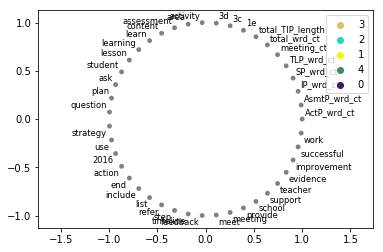

In [70]:
from pandas.plotting import radviz
data = TIP_for_AP
plt.figure()
radviz(data, 'rating_to_predict')

In [ ]:
plt.figure()
parallel_coordinates(data, 'rating_to_predict', colormap='gist_rainbow')